#Random Walks with GAN
### Can AI tell the difference?
This project aims to check whether it is possible to distinguish between random walks generated with a standard incremental method and those generated with generative adversarial networks. It can be hard for a human eye to see the difference, but it remains to be checked if artificial intelligence can do so effectively.

The project will be composed of three parts:
1. Data preparation
2. GAN setup
3. Classification of plots with CNN

We hope that this will provide an answer to the question we would like to investigate. We are certain that the models can be optimized in many ways and we do not intend to create a bulletproof solution, but rather to shed a light onto the subject.

### Project setup
In this section, we will make the necessary setup for our project, such as importing all the relevant packages, setting up all global variables etc. This will impact the project outcome and the user is welcome to change the values to observe the different results.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from keras import models, layers

(The algorithm performs best when provided the following metavariables set as shown below.)

In [ ]:
#this variable determines the size of the RW sample
SAMPLE_SIZE = 200

#this array will be a unified argument space for the RW sample
argument = np.linspace(0,1,SAMPLE_SIZE+1)

#this variables determine the dataset characteristics
DATA_SIZE = 100000
BATCH_SIZE = 500

#this variables determine the GAN learning process
EPOCHS = 1000
NODES = SAMPLE_SIZE+1
DISC_ENTRY = (int(NODES/4)+1)*4

#this variables determine the CNN learning process
ITER = 1000
SEED = 123
CNN_EPOCH = 10
CNN_BATCH = 50

### Data preparation
In this section, we will generate a dataframe with multiple entries of random walks generated with a standard incremental method. The method can be described as follows:

Let $[0,1]$ be the standard argument space for the random walk. We will approximate the continuous random walk $(W_t)_{t\in[0,1]}$ with a sequence of jumps. Let $S\in\mathbb{N}$ be the amount of steps we will simulate. Thus we separate $[0,1]$ into $S$ subintervals of equal length $h_\text{step}=\frac{1}{S}$.

We assume that $\text{jump}$ is a random variable with the standard normal distribution $N(0,1)$. Now we simulate the path of a random walk starting in the origin $(0,0)$ inductively using the following rule:
  \begin{array}{ll}
  &x_n = x_{n-1}+h_\text{step},\\
  &y_n = y_{n-1}+\text{jump}*\sqrt{h_\text{step}}
  \end{array}


The resulting sequence $(x_n, y_n)_{n=0}^S$ is an approximate trajectory of the random walk in $[0,1]\times\mathbb{R}$.

In [ ]:
def RW_generator(sample_size=SAMPLE_SIZE):
  h_step = 1/sample_size
  P_value = 0
  sample = [0]
  for i in range(sample_size):
    P_value += np.sqrt(h_step)*np.random.normal(0,1)
    sample.append(P_value)

  return sample

In [ ]:
real_data = []
for i in range(DATA_SIZE):
  real_data.append(RW_generator())

train_dataset = tf.data.Dataset.from_tensor_slices(real_data).shuffle(DATA_SIZE).batch(BATCH_SIZE)

### GAN setup
In this section, we will define the GAN neural network. It will require the definition of a discriminator and a generator model, which will be combined to form a fully operational GAN. Note that the definition of both models is dynamic, based on the dataset characteristics. This proved to be the best solution, since the dataset specifics may vary.

####Tensorflow implementation

In [ ]:
def generator_func():
  model = models.Sequential()

  model.add(layers.Dense(NODES))
  model.add(layers.ReLU())

  model.add(layers.Dense(2*NODES))
  model.add(layers.ReLU())

  model.add(layers.Dense(NODES))
  model.add(layers.ReLU())

  model.add(layers.Dense(SAMPLE_SIZE+1))

  return model



In [ ]:
def discriminator_func():
  model = models.Sequential()

  model.add(layers.Dense(DISC_ENTRY))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(DISC_ENTRY/2))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(DISC_ENTRY/4))
  model.add(layers.ReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(1))

  return model



In [ ]:
generator = generator_func()
discriminator = discriminator_func()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


gen_optimizer = tf.keras.optimizers.Adam()
disc_optimizer = tf.keras.optimizers.Adam()

In [ ]:
@tf.function
def train_step(data):

  fake_data = tf.random.uniform(minval=-1, maxval=1, shape=[BATCH_SIZE, SAMPLE_SIZE+1])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_data = generator(fake_data, training=True)

    real_output = discriminator(data, training=True)
    fake_output = discriminator(generated_data, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
  disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
  disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

  return gen_loss, disc_loss


def train(dataset, epochs):
  gen_hist, disc_hist = [], []
  for epoch in range(epochs):
    gen_sum, disc_sum = 0, 0

    for data_batch in dataset:
      gen_loss, disc_loss = train_step(data_batch)
      gen_sum += gen_loss
      disc_sum += disc_loss

    gen_hist.append(gen_sum)
    disc_hist.append(disc_sum)

  return gen_hist, disc_hist


(Note that we store a cumulative loss from each epoch of the training process for both generator and discriminator function.)

In [ ]:
gen_hist, disc_hist = train(train_dataset, EPOCHS)

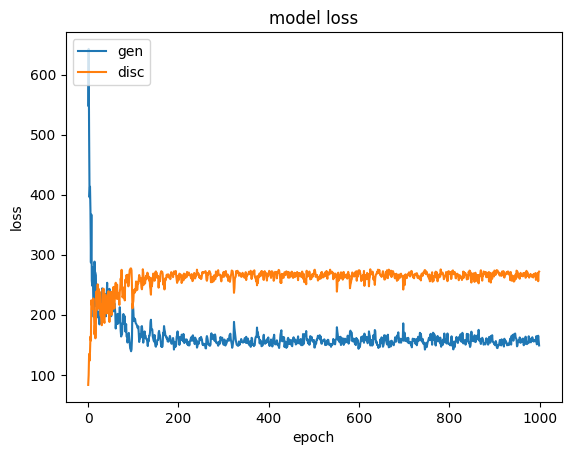

In [ ]:
plt.plot(gen_hist)
plt.plot(disc_hist)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['gen', 'disc'], loc='upper left')
plt.show()

We are ready to investigate the outcome of the learning process for GAN. The best way is to simply compare the images generated by the network with those generated with the incremental method.

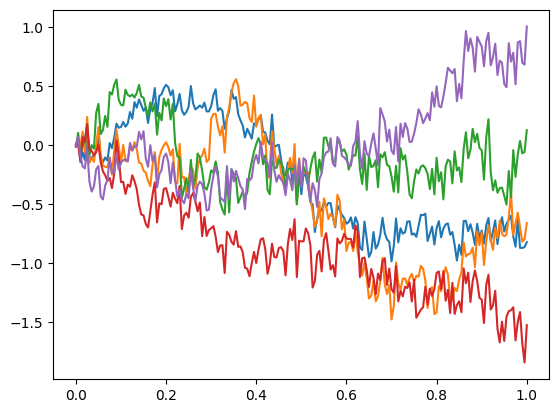

In [ ]:
fake_data = tf.random.uniform(minval=-1, maxval=1, shape=[BATCH_SIZE, SAMPLE_SIZE+1])

output = generator(fake_data)
indice = np.random.choice(BATCH_SIZE, 5)

for element in indice:
  plt.plot(argument, np.array(output[element]).transpose())
plt.show()

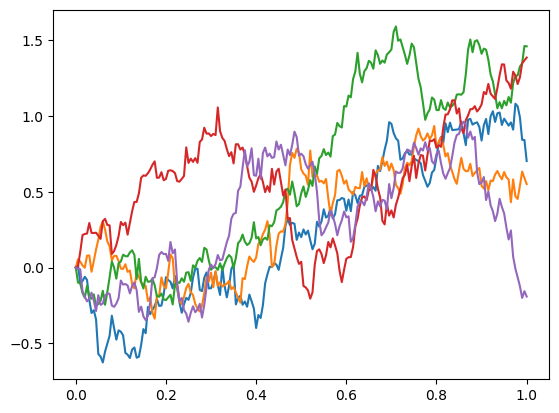

In [ ]:
indices = np.random.choice(DATA_SIZE, 5)

for element in indices:
  plt.plot(argument, np.array(real_data[element]).transpose())
plt.show()

The network shows satisfactory results after the training process. Note that we chose the best performing metaparameters.

### CNN Setup
In this section we will try to train the convolutional neural network to distinguish between GAN-generated and Increment-generated random walks.

#### Image data preparation

In [ ]:
#CLEAR THE STORED DATA
!rm -fr plots

#This line deletes a reduntant folder in the file structure which interferes with loading the dataset
!rm -rf plots/.ipynb_checkpoints/

!mkdir plots
!mkdir plots/GAN plots/INC

In [ ]:
#DATA_TO_FILE

for i in range(ITER):
  fake_data = tf.random.uniform(minval=-1, maxval=1, shape=[BATCH_SIZE, SAMPLE_SIZE+1])

  output = generator(fake_data)
  indice = np.random.choice(BATCH_SIZE, 1)

  for element in indice:
    plt.plot(argument, np.array(output[element]).transpose())
    plt.axis(False)
    plt.savefig(f'plots/GAN/{i}.png')
    plt.clf()

    plt.plot(argument, np.array(real_data[element]).transpose())
    plt.axis(False)
    plt.savefig(f'plots/INC/{i}.png')
    plt.clf()


<Figure size 640x480 with 0 Axes>

In [ ]:
#CREATE DATASET

data_dir = 'plots/'

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed = SEED,
  batch_size = CNN_BATCH)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed = SEED,
  batch_size = CNN_BATCH)


Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


#### Tensorflow implementation
In this section we will define a standard CNN model for image classification. We will use the class methods from tensorflow library to compile and train this model.

In [ ]:
def CNN_model():
  model = models.Sequential()

  model.add(layers.Rescaling(1./255))

  model.add(layers.Conv2D(32, 3, activation='relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(64, 3, activation='relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Conv2D(32, 3, activation='relu'))
  model.add(layers.MaxPooling2D())

  model.add(layers.Flatten())
  model.add(layers.Dense(128))

  model.add(layers.Dense(2))

  return model


In [ ]:
cnn_model = CNN_model()
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

cnn_model.compile(optimizer = 'adam', loss = loss_func, metrics=['accuracy'])

In [ ]:
history = cnn_model.fit(train_ds, validation_data = val_ds, epochs = CNN_EPOCH)

Epoch 1/10
32/32 [==============================] - 19s 272ms/step - loss: 1.2479 - accuracy: 0.5419 - val_loss: 0.5178 - val_accuracy: 0.7925
Epoch 2/10
32/32 [==============================] - 9s 240ms/step - loss: 0.4435 - accuracy: 0.8106 - val_loss: 0.2588 - val_accuracy: 0.9100
Epoch 3/10
32/32 [==============================] - 10s 243ms/step - loss: 0.1779 - accuracy: 0.9419 - val_loss: 0.1026 - val_accuracy: 0.9600
Epoch 4/10
32/32 [==============================] - 10s 269ms/step - loss: 0.0600 - accuracy: 0.9875 - val_loss: 0.0439 - val_accuracy: 0.9875
Epoch 5/10
32/32 [==============================] - 11s 304ms/step - loss: 0.0242 - accuracy: 0.9950 - val_loss: 0.0867 - val_accuracy: 0.9675
Epoch 6/10
32/32 [==============================] - 10s 276ms/step - loss: 0.0178 - accuracy: 0.9969 - val_loss: 0.0216 - val_accuracy: 0.9950
Epoch 7/10
32/32 [==============================] - 10s 272ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 0.9950


We are ready to evaluate the performance of CNN. Since we have automatic validation, we will simply plot the history of CNN training process.

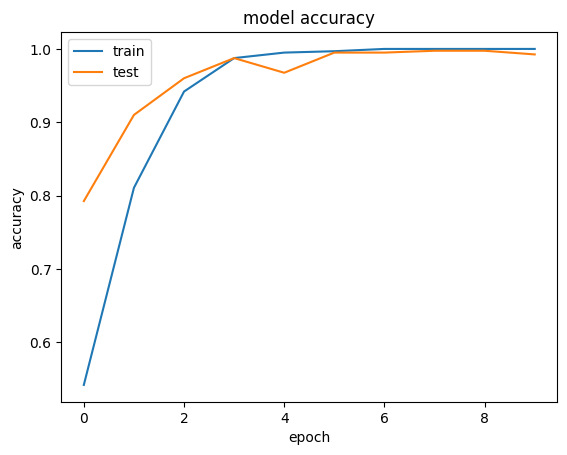

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

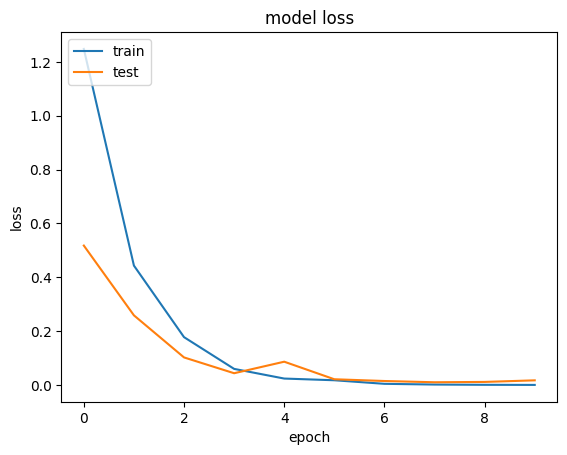

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The network works almost flawlessly after the training process.

### Results
In this section, we will discuss the outcomes of the project.

One can see that the GAN neural network can be trained to successfully immitate random walks defined using the incremental method. Note that to achieve that, one needs to choose the metaparameters wisely. When the argument space is too dense, the algorithm does not perform well enough, no matter the amount of data provided. So far, no solution to this problem has been found.

On the other hand, one can see that we can train the CNN neural network to successfully distinguish between trajectories generated either by a trained GAN or in a standard increment way.

Summing up, in this particular matter, we can make AI fool a human, but not itself.